In [1]:
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

def print_array(**kwargs):
    for key, val in kwargs.items():
        print(f'{key} ∈ {val.dtype} {val.shape}')

In [270]:
data = scipy.io.loadmat('cylinder.mat')

n_x = data['nx'].item()
n_y = data['ny'].item()
n_t = 250

x = data['X']
y = data['Y']
u = data['U']
v = data['V']

print_array(x=x, y=y, u=u, v=v)

x ∈ float64 (251, 501)
y ∈ float64 (251, 501)
u ∈ float64 (125751, 250)
v ∈ float64 (125751, 250)


In [271]:
# 1a
phi_u, sigma_u, V_u = scipy.sparse.linalg.svds(u, 50, which='LM')
phi_v, sigma_v, V_v = scipy.sparse.linalg.svds(v, 50, which='LM')

print_array(phi_u=phi_u, sigma_u=sigma_u, V_u=V_u)

# scipy returns V, not V_T like numpy does

# scipy also sorts the singular values in INCREASING order
#   but we want them in DECREASING order to get top modes
phi_u = phi_u[...,::-1]
phi_v = phi_v[...,::-1]
sigma_u = sigma_u[::-1]
sigma_v = sigma_v[::-1]
V_u = V_u[::-1]
V_v = V_v[::-1]

phi_u ∈ float64 (125751, 50)
sigma_u ∈ float64 (50,)
V_u ∈ float64 (50, 250)


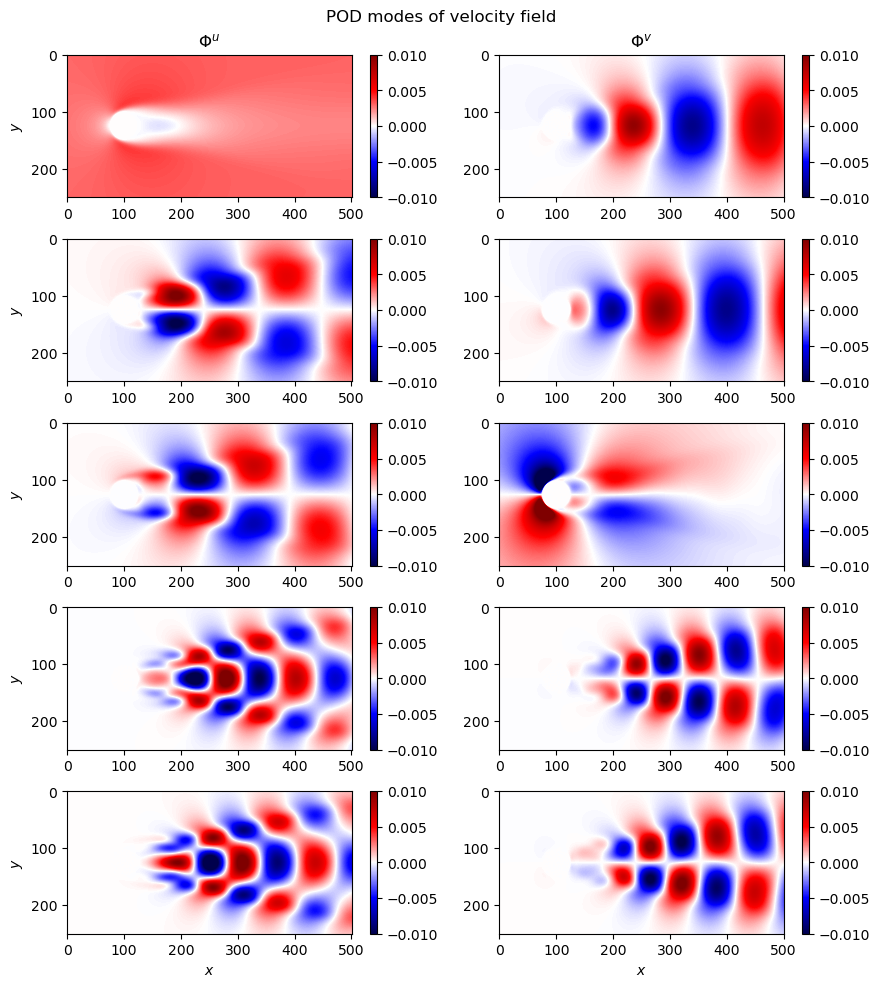

In [272]:
# 1b
fig, ax = plt.subplots(5, 2, figsize=(9, 10))

fig.suptitle('POD modes of velocity field')

ax[0,0].set_title('$\Phi^u$')
ax[0,1].set_title('$\Phi^v$')
ax[-1,0].set_xlabel('$x$')
ax[-1,1].set_xlabel('$x$')

for i in range(5):
    ax[i,0].set_ylabel('$y$')
    im = ax[i,0].imshow(
        phi_u[...,i].reshape(n_x, n_y).T,
        cmap='seismic', vmin=-1e-2, vmax=1e-2
    )
    plt.colorbar(im)
    im = ax[i,1].imshow(
        phi_v[...,i].reshape(n_x, n_y).T,
        cmap='seismic', vmin=-1e-2, vmax=1e-2
    )
    plt.colorbar(im)
    
fig.tight_layout()

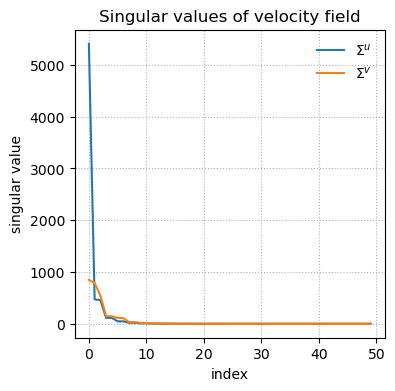

In [273]:
# 1c
fig, ax = plt.subplots(figsize=(4,4))
ax.set_title('Singular values of velocity field')
ax.plot(sigma_u, label='$\Sigma^u$')
ax.plot(sigma_v, label='$\Sigma^v$')
ax.legend(frameon=False)
ax.set_ylabel('singular value')
ax.set_xlabel('index')
ax.grid(linestyle=':')

In [274]:
# 1d
energy_u = np.cumsum(sigma_u**2) / np.sum(sigma_u**2)
energy_v = np.cumsum(sigma_v**2) / np.sum(sigma_v**2)
print(energy_u[::10])
print(energy_v[::10])

[0.98452259 0.9999991  1.         1.         1.        ]
[0.42140238 0.99995628 0.99999996 1.         1.        ]


We can capture over 99% of the energy in the velocity data by using the first 2 modes of both the U component and V component.

phi_u ∈ float64 (125751, 50)
sigma_u ∈ float64 (50,)
V_u ∈ float64 (50, 250)


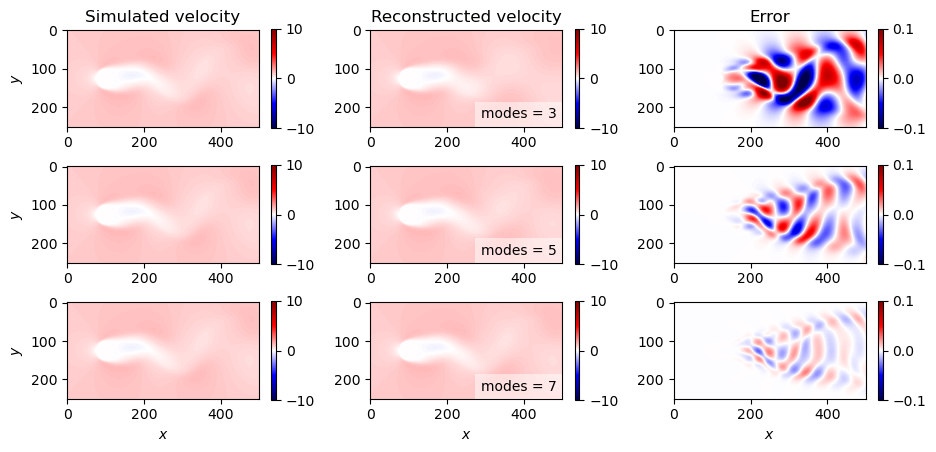

In [275]:
# 2
# qualitative comparison for U component only

print_array(phi_u=phi_u, sigma_u=sigma_u, V_u=V_u)

fig, ax = plt.subplots(3, 3, figsize=(9.5, 4.5))

ax[0,0].set_title('Simulated velocity')
ax[0,1].set_title('Reconstructed velocity')
ax[0,2].set_title('Error')


ax[-1,0].set_xlabel('$x$')
ax[-1,1].set_xlabel('$x$')
ax[-1,2].set_xlabel('$x$')

t = 100 # python uses 0-based indexing, MATLAB uses 1-based
modes = [3, 5, 7]
u_errors = []
v_errors = []
for i, n_modes in enumerate(modes):
    
    # evaluate y(t) at time step t_101
    #   these are the weights for spatial basis functions
    #   we will use for low-rank approximation
    y_u = np.diag(sigma_u[:n_modes]) @ V_u[:n_modes,t]
    y_v = np.diag(sigma_v[:n_modes]) @ V_v[:n_modes,t]
    
    # low-rank reconstruction of velocity field
    u_r = phi_u[:,:n_modes] @ y_u
    v_r = phi_v[:,:n_modes] @ y_v
    
    # error between simulated and reconstructed velocity
    u_error = u[...,t] - u_r
    v_error = v[...,t] - v_r
    
    u_errors.append((u_error**2).sum() / (u[...,t]**2).sum())
    v_errors.append((v_error**2).sum() / (v[...,t]**2).sum())
    
    ax[i,0].set_ylabel('$y$')
    
    # simulated velocity
    im = ax[i,0].imshow(
        u[...,t].reshape(n_x, n_y).T,
        cmap='seismic', vmin=-1e1, vmax=1e1
    )
    plt.colorbar(im)
    
    # reconstructed velocity
    im = ax[i,1].imshow(
        u_r.reshape(n_x, n_y).T,
        cmap='seismic', vmin=-1e1, vmax=1e1
    )
    ax[i,1].text(
        0.970, 0.085, f'modes = {n_modes}', ha='right', transform=ax[i,1].transAxes,
        bbox=dict(facecolor='w', alpha=0.5, linewidth=0)
    )
    plt.colorbar(im)
    
    # error
    im = ax[i,2].imshow(
        u_error.reshape(n_x, n_y).T,
        cmap='seismic', vmin=-1e-1, vmax=1e-1
    )
    plt.colorbar(im)

fig.tight_layout()

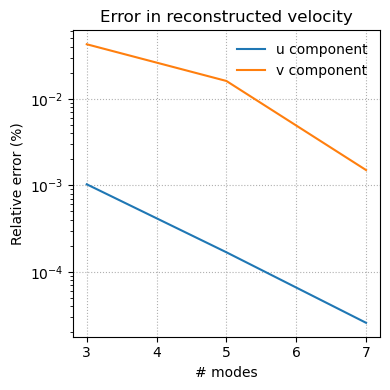

In [276]:
# quantitative comparison for both components

print

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(modes, u_errors, label='u component')
ax.plot(modes, v_errors, label='v component')
ax.set_title('Error in reconstructed velocity')
ax.set_yscale('log')
ax.set_ylabel('Relative error (%)')
ax.set_xlabel('# modes')
ax.legend(frameon=False)
ax.grid(linestyle=':')
fig.tight_layout()

In [277]:
# 3a

def coords(x0, n_x, dx):
    return x0 + np.arange(n_x) * dx

def indices(start, num, step):
    stop = start + num * step
    return slice(start, stop, step)

# sensor spacing
dx = 20 * data['dx'].item()
dy = 20 * data['dy'].item()

# CASE 1

# sensor coordinates
x_vals1 = coords(2, 5, dx)
y_vals1 = coords(0.2, 2, dy)

# indices of sensor nodes
x_inds1 = indices(200, 5, 20)
y_inds1 = indices(135, 2, 20)

# CASE 2

# sensor coordinates
x_vals2 = coords(2, 5, dx)
y_vals2 = coords(-1.9, 2, dy)

# indices of sensor nodes
x_inds2 = indices(200, 5, 20)
y_inds2 = indices(30, 2, 20)

# check that indices are correct
assert np.allclose(x_vals1, x[0,x_inds1])
assert np.allclose(y_vals1, y[y_inds1,0])
assert np.allclose(x_vals2, x[0,x_inds2])
assert np.allclose(y_vals2, y[y_inds2,0])

y_u ∈ float64 (5, 250)
thetas ∈ float64 (2, 250, 5)


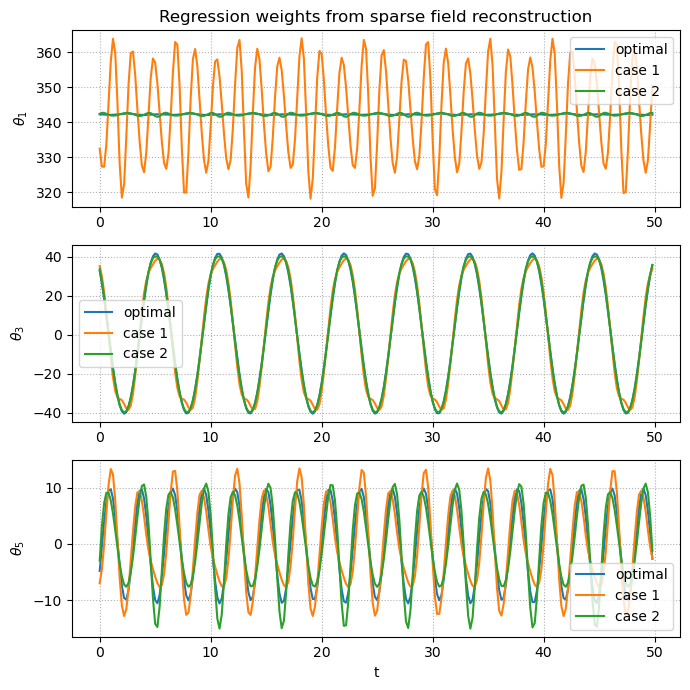

In [278]:
# 3b

def linear_fit(y, phi):
    A, b = phi.T @ phi, phi.T @ y
    return np.linalg.solve(A, b)

# reshape velocity and basis functions
u = u.reshape(n_x, n_y, n_t)
phi_u = phi_u.reshape(n_x, n_y, -1)

n_modes = 5

cases = [
    (x_inds1, y_inds1),
    (x_inds2, y_inds2)
]
thetas = [[], []]

# for each set of sensor locations,
for i, (x_inds, y_inds) in enumerate(cases):

    # for each time step,
    for k in range(n_t):

        # get sensor measurements
        u_m = u[x_inds,y_inds,k]

        # evaluate basis functions
        phi_x = phi_u[x_inds,y_inds,:n_modes]

        # need to flatten again
        u_m = u_m.reshape(-1)
        phi_x = phi_x.reshape(-1, n_modes)

        # linear fit to measurements
        theta = linear_fit(u_m, phi_x)
        thetas[i].append(theta)

        # reconstructed velocity field
        u_hat = phi_u[:,:,:n_modes] @ theta
    
# stack the fit parameters
thetas = np.array(thetas)
    
# optimal theta values
y_u = np.diag(sigma_u[:n_modes]) @ V_u[:n_modes]
print_array(y_u=y_u, thetas=thetas)

# time steps
t_vals = coords(0, n_t, 0.2)

fig, ax = plt.subplots(3, 1, figsize=(7,7))
ax[0].set_title('Regression weights from sparse field reconstruction')

for i, theta_idx in enumerate([0, 2, 4]):
    ax[i].plot(t_vals, y_u[theta_idx], label='optimal')
    ax[i].plot(t_vals, thetas[0,:,theta_idx], label='case 1')
    ax[i].plot(t_vals, thetas[1,:,theta_idx], label='case 2')
    ax[i].legend()
    ax[i].grid(linestyle=':')
    ax[i].set_ylabel(f'$\\theta_{theta_idx+1}$')
    fig.tight_layout()
    
ax[-1].set_xlabel('t')
fig.tight_layout()

The sensor locations from case 2 are providing better data for sparse field reconstruction, as the recovered theta values are closer to the optimal values that were determined by applying SVD to the simulated data.

In [284]:
# 3c

k = 100
assert np.isclose(t_vals[k], 20) # t = 20

print_array(thetas=thetas, u=u)

# reconstructed velocity field
u_hat1 = phi_u[:,:,:n_modes] @ thetas[0,k]
u_hat2 = phi_u[:,:,:n_modes] @ thetas[1,k]

print_array(u_hat1=u_hat1)

norm = np.linalg.norm(u[:,:,k])
error1 = np.linalg.norm(u_hat1 - u[:,:,k])
error2 = np.linalg.norm(u_hat2 - u[:,:,k])

print(error1, error1 / norm * 100)
print(error2, error2 / norm * 100)

thetas ∈ float64 (2, 250, 5)
u ∈ float64 (501, 251, 250)
u_hat1 ∈ float64 (501, 251)
18.562330145461264 5.380355040424209
5.187270877972474 1.5035482504425297


The case 1 reconstruction has error norm of 18.56 (5.38%) compared to 5.18 (1.5%) for the case 2 reconstruction. This confirms that the case 2 sensor locations are better than those in case 1.

thetas ∈ float64 (2, 250, 5)
u ∈ float64 (501, 251, 250)
u_hat0 ∈ float64 (250,)
t_vals ∈ float64 (250,)


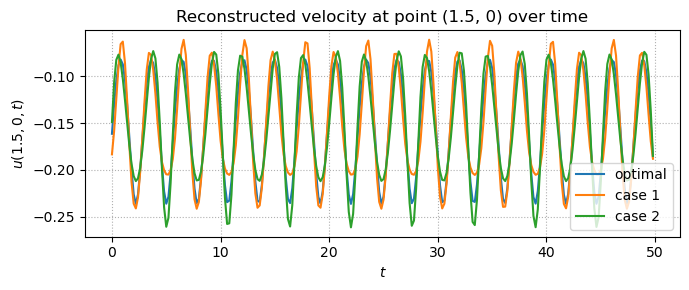

In [321]:
# 3d

i, j = (175, 125)
assert np.isclose(x[0,i], 1.5)
assert np.isclose(y[j,0], 0.0)

print_array(thetas=thetas, u=u)

u_hat0 = []
u_hat1 = []
for k in range(n_t):
    u_hat0.append(phi_u[i,j,:n_modes] @ thetas[0,k])
    u_hat1.append(phi_u[i,j,:n_modes] @ thetas[1,k])

u_hat0 = np.array(u_hat0)
u_hat1 = np.array(u_hat1)

print_array(u_hat0=u_hat0, t_vals=t_vals)

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(t_vals, u[i,j], label='optimal')
ax.plot(t_vals, u_hat0, label='case 1')
ax.plot(t_vals, u_hat1, label='case 2')
ax.grid(linestyle=':')
ax.legend()
ax.set_ylabel('$u(1.5,0,t)$')
ax.set_xlabel('$t$')
ax.set_title('Reconstructed velocity at point (1.5, 0) over time')
fig.tight_layout()

In [325]:
# 4a

# add noise to velocity field
print_array(u=u)

np.random.seed(0)
u_n = u + 0.02 * np.random.randn(*u.shape)

u ∈ float64 (501, 251, 250)


y_u ∈ float64 (5, 250)
thetas ∈ float64 (2, 250, 5)


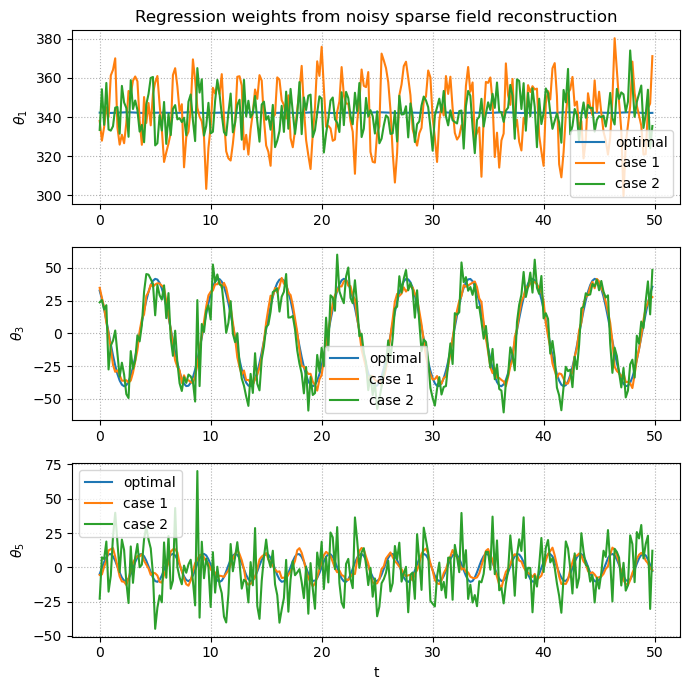

In [327]:
# 4b

# reshape noise velocity field
u_n = u_n.reshape(n_x, n_y, n_t)

thetas = [[], []]

# for each set of sensor locations,
for i, (x_inds, y_inds) in enumerate(cases):

    # for each time step,
    for k in range(n_t):

        # get sensor measurements
        u_m = u_n[x_inds,y_inds,k]

        # evaluate basis functions
        phi_x = phi_u[x_inds,y_inds,:n_modes]

        # need to flatten again
        u_m = u_m.reshape(-1)
        phi_x = phi_x.reshape(-1, n_modes)

        # linear fit to measurements
        theta = linear_fit(u_m, phi_x)
        thetas[i].append(theta)

        # reconstructed velocity field
        u_hat = phi_u[:,:,:n_modes] @ theta
    
# stack the fit parameters
thetas = np.array(thetas)
    
# optimal theta values
y_u = np.diag(sigma_u[:n_modes]) @ V_u[:n_modes]
print_array(y_u=y_u, thetas=thetas)

# time steps
t_vals = coords(0, n_t, 0.2)

fig, ax = plt.subplots(3, 1, figsize=(7,7))
ax[0].set_title('Regression weights from noisy sparse field reconstruction')

for i, theta_idx in enumerate([0, 2, 4]):
    ax[i].plot(t_vals, y_u[theta_idx], label='optimal')
    ax[i].plot(t_vals, thetas[0,:,theta_idx], label='case 1')
    ax[i].plot(t_vals, thetas[1,:,theta_idx], label='case 2')
    ax[i].legend()
    ax[i].grid(linestyle=':')
    ax[i].set_ylabel(f'$\\theta_{theta_idx+1}$')
    fig.tight_layout()
    
ax[-1].set_xlabel('t')
fig.tight_layout()

In [330]:
# 4c

k = 100
assert np.isclose(t_vals[k], 20) # t = 20

print_array(thetas=thetas, u_n=u_n)

# reconstructed velocity field
u_hat1 = phi_u[:,:,:n_modes] @ thetas[0,k]
u_hat2 = phi_u[:,:,:n_modes] @ thetas[1,k]

print_array(u_hat1=u_hat1)

norm = np.linalg.norm(u[:,:,k])
error1 = np.linalg.norm(u_hat1 - u_n[:,:,k])
error2 = np.linalg.norm(u_hat2 - u_n[:,:,k])

print(error1, error1 / norm * 100)
print(error2, error2 / norm * 100)

thetas ∈ float64 (2, 250, 5)
u_n ∈ float64 (501, 251, 250)
u_hat1 ∈ float64 (501, 251)
35.64737900442047 10.332515034554666
29.94024978078031 8.678284060095203


thetas ∈ float64 (2, 250, 5)
u ∈ float64 (501, 251, 250)
u_hat0 ∈ float64 (250,)
t_vals ∈ float64 (250,)


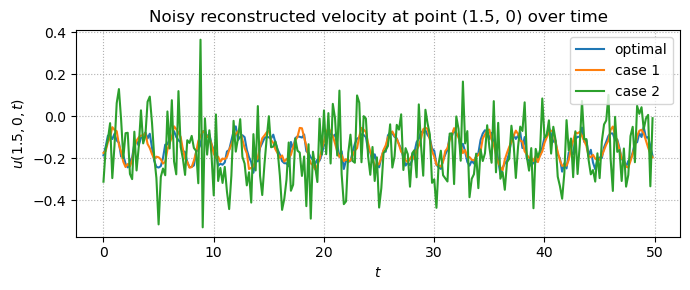

In [331]:
# 3d

i, j = (175, 125)
assert np.isclose(x[0,i], 1.5)
assert np.isclose(y[j,0], 0.0)

print_array(thetas=thetas, u=u_n)

u_hat0 = []
u_hat1 = []
for k in range(n_t):
    u_hat0.append(phi_u[i,j,:n_modes] @ thetas[0,k])
    u_hat1.append(phi_u[i,j,:n_modes] @ thetas[1,k])

u_hat0 = np.array(u_hat0)
u_hat1 = np.array(u_hat1)

print_array(u_hat0=u_hat0, t_vals=t_vals)

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(t_vals, u_n[i,j], label='optimal')
ax.plot(t_vals, u_hat0, label='case 1')
ax.plot(t_vals, u_hat1, label='case 2')
ax.grid(linestyle=':')
ax.legend()
ax.set_ylabel('$u(1.5,0,t)$')
ax.set_xlabel('$t$')
ax.set_title('Noisy reconstructed velocity at point (1.5, 0) over time')
fig.tight_layout()